# Evaluating 2D FMPC, comparing to MPC_acados

In [1]:
import numpy as np
import os
import sys
import matplotlib.pyplot as plt

# Functions

In [2]:
def extract_rollouts(notebook_dir, data_folder, controller_name, additional=''):
    # print('notebook_dir', notebook_dir)
    data_folder_path = os.path.join(notebook_dir, controller_name, data_folder)
    # print('data_folder_path', data_folder_path)
    assert os.path.exists(data_folder_path), 'data_folder_path does not exist'

    # find all the subfolders in the data_folder_path
    subfolders = [f.path for f in os.scandir(data_folder_path) if f.is_dir()]
    # print('subfolders', subfolders)
    # load the row 'rmse in the metrics.txt
    metrics = []
    traj_resutls = []
    mse_results = []
    for subfolder in subfolders:
        file_path = os.path.join(subfolder, 'metrics.txt')
        with open(file_path, 'r') as file:
            lines = file.readlines()
            for line in lines:
                if not line.startswith('rmse_std') and line.startswith('rmse'):
                    # split the text between : and \n
                    line = line.split(': ')[-1].split('\n')[0]
                    metrics.append(eval(line))

        # find the file ends with pickle and get the data
        for file in os.listdir(subfolder):
            if file.endswith('.pkl'):
                file_path = os.path.join(subfolder, file)
                # print('file_path', file_path)
                results = np.load(file_path, allow_pickle=True)
                traj_data = results['trajs_data']['obs'][0]
                traj_resutls.append(traj_data)

                # get mse of each timestep
                # if the data field is contained in step info dict
                episode_data = []
                for ep_info in results['trajs_data']['info']:
                    ep_info_data = []
                    for info in ep_info:
                        if 'mse' in info:
                            ep_info_data.append(info.get('mse'))
                    episode_data.append(np.array(ep_info_data)) 
                mse_results.append(episode_data)
            

    traj_resutls = np.array(traj_resutls)
    mse_results = np.array(mse_results)
    mse_results = np.squeeze(mse_results)
    # traj_file_name = f'traj_results_{controller_name}{additional}.npy'
    # np.save(traj_file_name, traj_resutls)
    print('traj_results.shape', traj_resutls.shape)
    # print('metrics', metrics)
    rmse_mean_mpc = np.mean(metrics)
    rmse_std_mpc = np.std(metrics)
    print(f'rmse_{controller_name}{additional}', rmse_mean_mpc, rmse_std_mpc)
    return traj_resutls, metrics, mse_results


In [3]:
from scipy.spatial import ConvexHull
from matplotlib.patches import Polygon
def plot_xz_trajectory_with_hull(ax, traj_data, label=None, 
                                 traj_color='skyblue', hull_color='lightblue',
                                 alpha=0.5, padding_factor=1.1):
    '''Plot trajectories with convex hull showing variance over seeds.
    
    Args:
        ax (Axes): Matplotlib axes.
        traj_data (np.ndarray): Trajectory data of shape (num_seeds, num_steps, 6).
        padding_factor (float): Padding factor for the convex hull.
    '''
    num_seeds, num_steps, _ = traj_data.shape

    print('traj data shape:', traj_data.shape)
    mean_traj = np.mean(traj_data, axis=0)
    
    ax.plot(mean_traj[:, 0], mean_traj[:, 2], color=traj_color, label=label)
    # plot the hull
    for i in range(num_steps - 1):
        # plot the hull at a single step
        points_at_step = traj_data[:, i, [0, 2]]
        hull = ConvexHull(points_at_step)
        cent = np.mean(points_at_step, axis=0) # center
        pts = points_at_step[hull.vertices] # vertices
        poly = Polygon(padding_factor*(pts - cent) + cent, 
                       closed=True,  
                       capstyle='round', 
                       facecolor=hull_color,
                       alpha=alpha)
        ax.add_patch(poly)

        # connecting consecutive convex hulls
        points_at_next_step = traj_data[:, i+1, [0, 2]]
        points_connecting = np.concatenate([points_at_step, points_at_next_step], axis=0)
        hull_connecting = ConvexHull(points_connecting)
        cent_connecting = np.mean(points_connecting, axis=0)
        pts_connecting = points_connecting[hull_connecting.vertices]
        poly_connecting = Polygon(padding_factor*(pts_connecting - cent_connecting) + cent_connecting, 
                                  closed=True,  
                                  capstyle='round', 
                                  facecolor=hull_color,
                                  alpha=alpha)
        ax.add_patch(poly_connecting)

In [4]:
def run_rollouts(additional='' ):
    import mb_experiment_rollout
    start_seed = 10
    num_seed = 1
    algo = 'fmpc'
    num_runs_per_seed = 1

    for seed in range(start_seed, num_seed + start_seed):
        for _ in range(num_runs_per_seed):
            mb_experiment_rollout.run(seed=seed, Additional=additional, ALGO=algo)

In [5]:
def plot_trajectory(notebook_dir, data_folder, title):
    from safe_control_gym.utils.configuration import ConfigFactory
    from functools import partial
    from safe_control_gym.utils.registration import make
    #########################################################################
    # launch SCG to get reference trajectory X_GOAL
    ALGO = 'fmpc'
    SYS = 'quadrotor_2D_attitude'
    TASK = 'tracking'
    # PRIOR = '200_hpo'
    PRIOR = '100'
    agent = 'quadrotor' if SYS == 'quadrotor_2D' or SYS == 'quadrotor_2D_attitude' else SYS
    SAFETY_FILTER = None

    # check if the config file exists
    assert os.path.exists(f'./config_overrides/{SYS}_{TASK}.yaml'), f'../config_overrides/{SYS}_{TASK}.yaml does not exist'
    assert os.path.exists(f'./config_overrides/{ALGO}_{SYS}_{TASK}_{PRIOR}.yaml'), f'../config_overrides/{ALGO}_{SYS}_{TASK}_{PRIOR}.yaml does not exist'
    if SAFETY_FILTER is None:
        sys.argv[1:] = ['--algo', ALGO,
                        '--task', agent,
                        '--overrides',
                            f'./config_overrides/{SYS}_{TASK}.yaml',
                            f'./config_overrides/{ALGO}_{SYS}_{TASK}_{PRIOR}.yaml',
                        '--seed', '2',
                        '--use_gpu', 'True',
                        '--output_dir', f'./{ALGO}/results',
                            ]
    fac = ConfigFactory()
    fac.add_argument('--func', type=str, default='train', help='main function to run.')
    fac.add_argument('--n_episodes', type=int, default=1, help='number of episodes to run.')
    # merge config and create output directory
    config = fac.merge()
    # Create an environment
    env_func = partial(make,
                        config.task,
                        seed=config.seed,
                        **config.task_config
                        )
    random_env = env_func(gui=False)
    X_GOAL = random_env.X_GOAL
    ##########################################################################
    # load trajectory pkl files, load from folder
    controller_name = 'fmpc'
    fmpc_data_path = os.path.join(notebook_dir, controller_name, data_folder)
    assert os.path.exists(fmpc_data_path), 'data_folder_path does not exist'
    # fmpc_data_path = '/home/tobias/Studium/masterarbeit/code/safe-control-gym/benchmarking_sim/quadrotor/fmpc/results_rollout/temp'
    fmpc_data_dirs = [d for d in os.listdir(fmpc_data_path) if os.path.isdir(os.path.join(fmpc_data_path, d))]
    fmpc_traj_data_name = 'fmpc_data_quadrotor_traj_tracking.pkl'
    fmpc_traj_data_name = [os.path.join(d, fmpc_traj_data_name) for d in fmpc_data_dirs]

    fmpc_data = []
    for d in fmpc_traj_data_name:
        fmpc_data.append(np.load(os.path.join(fmpc_data_path, d), allow_pickle=True))
    fmpc_traj_data = [d['trajs_data']['obs'][0] for d in fmpc_data]
    fmpc_traj_data = np.array(fmpc_traj_data)
    print(fmpc_traj_data.shape) # seed, time_step, obs
    # take average of all seeds
    mpc_mean_traj_data = np.mean(fmpc_traj_data, axis=0)
    print(mpc_mean_traj_data.shape) # (mean_541, 6)


    # Define Colors
    ref_color = 'black'
    fmpc_color = 'purple'
    fmpc_hull_color = 'violet'

    # plot the state path x, z [0, 2]
    title_fontsize = 20
    legend_fontsize = 14
    axis_label_fontsize = 14
    axis_tick_fontsize = 12

    fig, ax = plt.subplots(figsize=(8, 4))
    # adjust the distance between title and the plot
    fig.subplots_adjust(top=0.2)
    ax.plot(X_GOAL[:, 0], X_GOAL[:, 2], color=ref_color, linestyle='-.', label='Reference')
    # ax.plot()
    ax.set_xlabel('$x$ [m]', fontsize=axis_label_fontsize)
    ax.set_ylabel('$z$ [m]', fontsize=axis_label_fontsize)
    ax.tick_params(axis='both', which='major', labelsize=axis_tick_fontsize)
    # ax.set_title('State path in $x$-$z$ plane')
    # set the super title
    # if not generalization:
    #     fig.suptitle(f'Evaluation ({plot_name})', fontsize=title_fontsize)
    # else:
    #     fig.suptitle(f'Generalization ({plot_name})', fontsize=title_fontsize)
    fig.suptitle(title, fontsize=title_fontsize)
    ax.set_ylim(0.35, 1.85)
    ax.set_xlim(-1.6, 1.6)
    fig.tight_layout()


    # plot the convex hull of each steps
    k = 1.1 # padding factor
    alpha = 0.2

    plot_xz_trajectory_with_hull(ax, fmpc_traj_data, label='FMPC',
                                    traj_color=fmpc_color, hull_color=fmpc_hull_color,
                                    alpha=alpha, padding_factor=k)

    ax.legend(ncol=5, loc='upper center', fontsize=legend_fontsize)

    fig.savefig(os.path.join(fmpc_data_path, 'xz_path_performance.png'), dpi=300, bbox_inches='tight')

# Run MPC_ACADOS Rollouts - Reference to compare to

In [6]:
notebook_dir = os.path.dirname(os.path.abspath('__file__'))
print('notebook_dir', notebook_dir)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
s = 2 # times of std

notebook_dir /home/tobias/Studium/masterarbeit/code/safe-control-gym/benchmarking_sim/quadrotor


In [ ]:
import mb_experiment_rollout
start_seed = 10
num_seed = 10
algo = 'mpc_acados'
num_runs_per_seed = 1
additional = ''

for seed in range(start_seed, num_seed + start_seed):
    for _ in range(num_runs_per_seed):
        mb_experiment_rollout.run(seed=seed, Additional=additional, ALGO=algo)

In [8]:
# get rmse overall value and over trajectory
ctrl = 'mpc_acados'
data_folder = f'results_rollout{additional}/temp'
traj_resutls_mpc, metrics_mpc, mse_data_mpc = extract_rollouts(notebook_dir, data_folder, ctrl, additional)

traj_results.shape (10, 661, 6)
rmse_mpc_acados 0.04676349325205464 0.006205827699533016


In [9]:
# sanity check: recreate rmse from SCG eval
rmse_data_check = np.sqrt(np.mean(mse_data_mpc, axis=1))
print(metrics_mpc)
print(rmse_data_check)
print(rmse_data_check - metrics_mpc)

[0.038365223372188846, 0.04720698097881524, 0.03859616891167079, 0.05166937582584034, 0.05279399554559567, 0.05229664657666273, 0.054355105174668274, 0.038145061123200506, 0.05060311703193835, 0.043603257979965684]
[0.03836522 0.04720698 0.03859617 0.05166938 0.052794   0.05229665
 0.05435511 0.03814506 0.05060312 0.04360326]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


# Run FMPC with acados

# DELETE THE FMPC FOLDER!!!!!!

In [ ]:
import mb_experiment_rollout
start_seed = 10
num_seed = 10
algo = 'fmpc'
num_runs_per_seed = 1
additional = ''

for seed in range(start_seed, num_seed + start_seed):
    for _ in range(num_runs_per_seed):
        mb_experiment_rollout.run(seed=seed, Additional=additional, ALGO=algo)

In [21]:
# get rmse overall value and over trajectory
ctrl = 'fmpc'
data_folder = f'results_rollout{additional}/temp'
traj_resutls_fmpc, metrics_fmpc, mse_data_fmpc = extract_rollouts(notebook_dir, data_folder, ctrl, additional)

traj_results.shape (10, 661, 6)
rmse_fmpc 0.071335602570633 0.006653161154286605


# Comparison and Plots

In [22]:
tracking_error_mpc = np.sqrt(mse_data_mpc)
tracking_error_mpc_mean = np.mean(tracking_error_mpc, axis=0) # averaged over runs
tracking_error_mpc_std = np.std(tracking_error_mpc, axis=0) 

tracking_error_fmpc = np.sqrt(mse_data_fmpc)
tracking_error_fmpc_mean = np.mean(tracking_error_fmpc, axis=0) # averaged over runs
tracking_error_fmpc_std = np.std(tracking_error_fmpc, axis=0) 



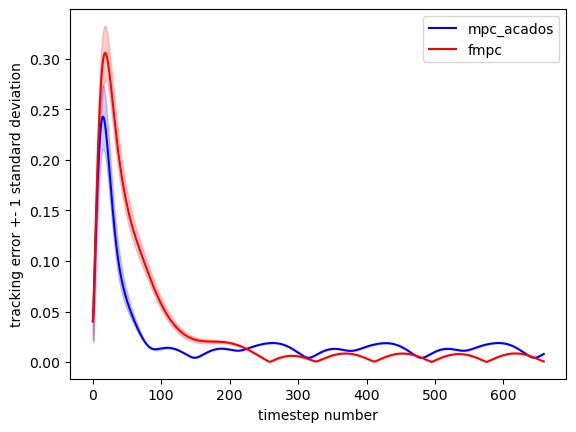

In [23]:
# plot tracking error over time
import matplotlib.pyplot as plt

timesteps = np.arange(0, len(tracking_error_mpc_mean))
std_factor = 1
plt.figure()

plt.plot(timesteps, tracking_error_mpc_mean, color='blue', label='mpc_acados')
plt.fill_between(timesteps, tracking_error_mpc_mean+tracking_error_mpc_std*std_factor,
                  tracking_error_mpc_mean-tracking_error_mpc_std*std_factor, 
                  color='blue', alpha=0.2)

plt.plot(timesteps, tracking_error_fmpc_mean, color='red', label='fmpc')
plt.fill_between(timesteps, tracking_error_fmpc_mean+tracking_error_fmpc_std*std_factor,
                  tracking_error_fmpc_mean-tracking_error_fmpc_std*std_factor, 
                  color='red', alpha=0.2)

y_label_text = 'tracking error +- {} standard deviation'.format(std_factor)
plt.ylabel(y_label_text)
plt.xlabel('timestep number')
plt.legend()

plt.savefig(os.path.join(notebook_dir, 'tracking_error.png'), dpi=300, bbox_inches='tight')

plt.show()

In [24]:
# performance metrics
first_loop_end = int(11/2*60)-1
#print(first_loop_end)
average_rmse_mpc = np.mean(np.sqrt(np.mean(mse_data_mpc, axis=1)))
average_rmse_mpc_1st_loop = np.mean(np.sqrt(np.mean(mse_data_mpc[:, :first_loop_end], axis=1)))
average_rmse_mpc_2nd_loop = np.mean(np.sqrt(np.mean(mse_data_mpc[:, first_loop_end:], axis=1)))

average_rmse_fmpc = np.mean(np.sqrt(np.mean(mse_data_fmpc, axis=1)))
average_rmse_fmpc_1st_loop = np.mean(np.sqrt(np.mean(mse_data_fmpc[:, :first_loop_end], axis=1)))
average_rmse_fmpc_2nd_loop = np.mean(np.sqrt(np.mean(mse_data_fmpc[:, first_loop_end:], axis=1)))

print('            MPC_acados | FMPC')
print(' average_rmse: {:.2f}mm | {:.2f}mm'.format(average_rmse_mpc*1000, average_rmse_fmpc*1000))
print('1st_loop_rmse: {:.2f}mm | {:.2f}mm'.format(average_rmse_mpc_1st_loop*1000, average_rmse_fmpc_1st_loop*1000))
print('2nd_loop_rmse: {:.2f}mm | {:.2f}mm'.format(average_rmse_mpc_2nd_loop*1000, average_rmse_fmpc_2nd_loop*1000))


            MPC_acados | FMPC
 average_rmse: 46.76mm | 71.34mm
1st_loop_rmse: 64.83mm | 100.86mm
2nd_loop_rmse: 13.40mm | 5.96mm


In [ ]:
# double check mean RMSE calculation in Tsungs eval. 
# calculate RMSE from exponentiated RMSE that is loged in txt file
expRMSE_baseline = np.array([0.9305845488056583, 0.9304426857807722, 0.9281569630732948, 0.9306818918858932, 0.9282261494854975])
expRMSE_vizier = np.array([0.9398041551468934, 0.9383339155888706, 0.9384341866308613, 0.9410820898019783, 0.9376986856896693])

rmse_baseline = - np.log(expRMSE_baseline)
rmse_vizier = -np.log(expRMSE_vizier)

print(np.mean(rmse_baseline))
print(np.mean(rmse_vizier))
# checks out, is the same

0.07298183741180685
0.06286544954584447


# OLD STUFF

In [ ]:
ctrl = 'fmpc'
# for additional in additionals_list:
#     data_folder = f'results_rollout{additional}/temp'
#     traj_resutls, metrics = extract_rollouts(notebook_dir, data_folder, ctrl, additional)

additional = ''
data_folder = f'results_rollout{additional}/temp'
traj_resutls, metrics, timing_data = extract_rollouts(notebook_dir, data_folder, ctrl, additional)
sp_plot_perf = np.mean(metrics) # spider plot performance

additional = '_slow'
data_folder = f'results_rollout{additional}/temp'
traj_resutls, metrics, _ = extract_rollouts(notebook_dir, data_folder, ctrl, additional)
sp_plot_gen_slow = np.mean(metrics) # spider plot generalization performance slow

additional = '_fast'
data_folder = f'results_rollout{additional}/temp'
traj_resutls, metrics, _ = extract_rollouts(notebook_dir, data_folder, ctrl, additional)
sp_plot_gen_fast = np.mean(metrics) # spider plot generalization performance fast

print('rmse_eval:', sp_plot_perf)
print('rmse_slow:', sp_plot_gen_slow)
print('rmse_fast:', sp_plot_gen_fast)

### Evaluate mean execution time --> Inference time in spider plot

# Plot Trajectory with Hull - like slide 8

Later this needs to be added to the other Model based algorithms, cannot do that right now as I don't have that data

In [ ]:
additional = ''
data_folder = f'results_rollout{additional}/temp'
plot_trajectory(notebook_dir, data_folder, 'Evaluation')

additional = '_slow'
data_folder = f'results_rollout{additional}/temp'
plot_trajectory(notebook_dir, data_folder, 'Generalization (slower)')

additional = '_fast'
data_folder = f'results_rollout{additional}/temp'
plot_trajectory(notebook_dir, data_folder, 'Generalization (faster)')